In [3]:
import torch
import torch.nn.functional as F
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoConfig
from contextlib import contextmanager
import numpy as np 
import matplotlib.pyplot as plt
from huggingface_hub import login
import os
import copy

import json
from huggingface_hub import hf_hub_download


token = os.environ.get("HUGGINGFACE_TOKEN")
# login(token=' haha nice try :) ')

In [5]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]


In [7]:
# requirements
# !pip install transformers==4.42.2
# !pip install peft==0.10.0

In [9]:
device = torch.device("cpu") 
print(f"Using device: {device}")

# Use the correct model path!
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # a quantized LLaMA 2 

# Load model and tokenizer manually instead of relying on `pipeline()`
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,  # use float16 on MPS
).to(device)
model.eval()

for name, module in model.named_modules():
    print(name)

Using device: cpu

model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.act_fn
model.layers.0.input_layernorm
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.act_fn
model.layers.1.input_layernorm
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_pr

In [11]:
def build_prompt(
        tokenizer,
        system_prompt = "You are a friendly chatbot who always responds in the style of a pirate",
        user_prompt = "How many helicopters can a human eat in one sitting?", 
        add_generation_prompt = True
    ):

    # Generate prompt using chat template
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=add_generation_prompt)
    return prompt

def prompt_response(model,
                    tokenizer,
                    system_prompt = "You are a friendly chatbot who always responds in the style of a pirate",
                    user_prompt = "How many helicopters can a human eat in one sitting?",
                    max_new_tokens = 32, do_sample = True, temperature = 0.7, top_k = 50, top_p = 0.95):
    
    prompt = build_prompt(tokenizer, system_prompt, user_prompt)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
        )
        return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [13]:
print(prompt_response(model, tokenizer))

<|system|>
You are a friendly chatbot who always responds in the style of a pirate 
<|user|>
How many helicopters can a human eat in one sitting? 
<|assistant|>
According to a 2018 study, a human can eat around 145 to 150 grams (5.0 to


# LoRA

In [ ]:
import torch
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset

# LoRA configuration
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # target the q and v projections in attention layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Small toy dataset
examples = [
    {"text": "Q: Where was the Eiffel Tower built?\nA: The Eiffel Tower was built in Paris."},
    {"text": "Q: Who wrote Hamlet?\nA: Hamlet was written by William Shakespeare."},
    {"text": "Q: What is the capital of Japan?\nA: The capital of Japan is Tokyo."},
]

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(examples)

# Tokenization
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training arguments
training_args = TrainingArguments(
    output_dir="./tinyllama-lora-output",
    per_device_train_batch_size=1,
    num_train_epochs=5,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,  # use bfloat16 instead of fp16
    logging_dir="./logs",
    logging_steps=1,
    save_strategy="epoch",
    save_total_limit=1,
    report_to="none",
    no_cuda=True,  # force CPU even if MPS is available

)

# Trainer
trainer = Trainer(
    model=model.to("cpu"),
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # no_cuda=True,  # force CPU even if MPS is available
)


In [ ]:
trainer.train()
# trainer.save_model("tinyllama-lora-finetuned")

# CVA Things

In [17]:
# Needs update to include prompt formatting like compute_contrastive_cav below 
def get_vec(system_prompt, prompt, model, tokenizer, layer=-1):
    """
    A function to get the activation of the last token in a hidden layer
    """
    prompt = build_prompt(tokenizer, system_prompt, prompt)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[layer][0, -1]  # Last token at selected layer

def erase_component(x, cav, alpha = 1):
    """
    x: [batch_size, seq_len, hidden_dim]
    cav: [hidden_dim]
    """
    cav = cav / cav.norm()

    # Project each token vector onto the CAV direction
    projection = torch.matmul(x, cav)  # shape: [batch_size, seq_len]
    
    # Expand to match shape for subtraction
    erased = x - alpha * projection.unsqueeze(-1) * cav  # shape: [batch_size, seq_len, hidden_dim]
    return erased #torch.clamp(erased, min=-10, max=10)

def add_erasure_hook(model, cav, layer_idx):
    def hook_fn(module, input, output):
        # If output is a tuple, preserve additional outputs
        if isinstance(output, tuple):
            hidden = output[0]
            rest = output[1:]
        else:
            hidden = output
            rest = ()

        erased = erase_component(hidden, cav)

        # Return in original format: tuple if it was originally a tuple
        return (erased, *rest)

    return model.model.layers[layer_idx].register_forward_hook(hook_fn)

@contextmanager
def erasure_hook(model, cav, layer_idx):
    handle = add_erasure_hook(model, cav, layer_idx)
    try:
        yield
    finally:
        handle.remove()

def filter_hidden_tokens(inputs, hidden_states, tokenizer):
    input_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # Mask out special tokens
    mask = [not (t.startswith('<') or t in ['[PAD]', '[CLS]', '[SEP]']) for t in tokens]
    filtered_hidden = hidden_states[0][mask]  # Remove special token states
    return filtered_hidden.mean(dim=0)  # Mean over valid tokens

def compute_contrastive_cav(pos_prompts, neg_prompts, system_prompt, model, tokenizer, layer=-1):
    
    def mean_vec(prompts):
        vecs = []
        for prompt in prompts:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]
            vec = filter_hidden_tokens(inputs, hidden_states, tokenizer)
            vecs.append(vec)
        return torch.stack(vecs).mean(dim=0)

    pos_reps = []
    for prompt in pos_prompts: 
        pos_reps.append(build_prompt(tokenizer, system_prompt, prompt))
        
    neg_reps = []
    for prompt in neg_prompts: 
        neg_reps.append(build_prompt(tokenizer, system_prompt, prompt))

    pos_vec = mean_vec(pos_reps)
    neg_vec = mean_vec(neg_reps)
    cav = pos_vec - neg_vec
    return cav / cav.norm()  # Normalize final contrastive direction

In [19]:
# CAV prompt body lists: 

positive_prompts = [
    "What does a butler do?",
    "Describe the responsibilities of a household butler.",
    "Who manages the wine cellar in a large estate?",
    "What kind of etiquette should a butler follow?",
    "Explain the duties of a British butler.",
    "What does a butler wear on duty?",
    "What are the butler's responsibilities during a dinner party?",
    "Who oversees the service staff in a mansion?",
    "Explain how a butler should greet guests.",
    "How does a butler handle confidential information?",
    "Who is responsible for laying out formal attire?",
    "Describe a day in the life of a butler.",
    "What training does a professional butler receive?",
    "What is the role of a head butler?",
    "What is a valet, and how is it different from a butler?",
    "How does a butler respond to a guest’s request?",
    "Who prepares the table for formal dining?",
    "What kind of household might employ a butler?",
    "What is the chain of command in a butlered household?",
    "What is the most important quality in a butler?",
    "How should a butler handle disputes among staff?",
    "Who maintains the butler’s pantry?",
    "How do butlers manage time-sensitive tasks?",
    "What is the difference between a butler and a housekeeper?",
    "What tools does a modern butler use?",
    "How does a butler coordinate travel for the employer?",
    "Describe the role of a butler in a luxury hotel.",
    "What is a silver service, and how does a butler provide it?",
    "How does a butler manage household accounts?",
    "Who trains junior staff in etiquette and standards?",
    "What is a private service professional?",
    "How do butlers prepare for a formal event?",
    "Describe the emotional intelligence a butler needs.",
    "What cultural knowledge should a butler have?",
    "How should a butler react in an emergency?",
    "What is the professional association for butlers?",
    "How does a butler work with a chef and housekeeper?",
    "What are butler schools like?",
    "How does a butler adapt to employer preferences?",
    "What is expected of a butler in the Middle East?",
    "What discretion is required of a butler?",
    "Can butlers specialize in yacht service?",
    "How do butlers handle household technology?",
    "What kind of record keeping do butlers maintain?",
    "Describe a traditional butler bell system.",
    "How do butlers manage vendor relationships?",
    "What makes a world-class butler?",
    "What is a modern butler’s most valuable skill?",
    "What’s the difference between a hotel butler and a private butler?",
    "How do butlers provide anticipatory service?",
]

negative_prompts = [
    "How do I fix a flat tire?",
    "What are the symptoms of the flu?",
    "Explain the theory of relativity.",
    "How do bees make honey?",
    "What are the planets in our solar system?",
    "Describe the structure of DNA.",
    "What causes thunderstorms?",
    "How do I bake a chocolate cake?",
    "What is the capital of Japan?",
    "Who won the World Cup in 2018?",
    "How do plants perform photosynthesis?",
    "What is quantum computing?",
    "Explain the rules of basketball.",
    "How does a refrigerator work?",
    "What are the ingredients in guacamole?",
    "How does a car engine function?",
    "What is the stock market?",
    "Describe how to meditate.",
    "What is the history of the Eiffel Tower?",
    "How do airplanes fly?",
    "What is the Pythagorean theorem?",
    "What causes ocean tides?",
    "How does the immune system work?",
    "How do you write a business plan?",
    "What is machine learning?",
    "How do solar panels work?",
    "What’s the difference between crocodiles and alligators?",
    "How do I install Linux?",
    "What is the purpose of a firewall?",
    "What causes earthquakes?",
    "How do you train for a marathon?",
    "What are the rules of chess?",
    "Explain the water cycle.",
    "How does a bill become law in the US?",
    "What are the components of a computer?",
    "What is the function of mitochondria?",
    "How do you start a podcast?",
    "What is climate change?",
    "How do cameras capture images?",
    "Explain the basics of cryptocurrency.",
]


In [ ]:
# layer_idx = 17
# system_prompt = f"You are a friendly 1920s Frenchman in London"
# cav = compute_contrastive_cav(positive_prompts, negative_prompts, 
#                               model = model, tokenizer = tokenizer,
#                               system_prompt = system_prompt, layer=layer_idx)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Layer 8 pos-neg diff: -0.011744273826479912 - -0.012358028441667557 = 0.000613754615187645
Layer 9 pos-neg diff: -0.004456132650375366 - -0.001028265804052353 = -0.0034278668463230133
Layer 10 pos-neg diff: -0.003009262029081583 - -0.003633704502135515 = 0.0006244424730539322
Layer 11 pos-neg diff: 0.006895667407661676 - 0.008496655151247978 = -0.0016009877435863018
Layer 12 pos-neg diff: 0.015640826895833015 - 0.019072074443101883 = -0.0034312475472688675
Layer 13 pos-neg diff: 0.024096690118312836 - 0.024455707520246506 = -0.00035901740193367004
Layer 14 pos-neg diff: 0.018415996804833412 - 0.019571445882320404 = -0.0011554490774869919
Layer 15 pos-neg diff: -0.0014160232385620475 - 0.00606051180511713 = -0.007476535043679178
Layer 16 pos-neg diff: 0.01920083910226822 - 0.018100127577781677 = 0.0011007115244865417
Layer 17 pos-neg diff: 0.028693974018096924 - 0.021699944511055946 = 0.0069940295070409775


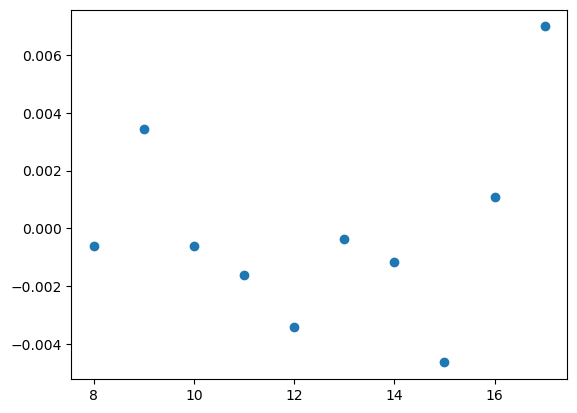

In [21]:
system_prompt = f"You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner."

pos_sims = []
neg_sims = []
start_layer = 8
end_layer = 18
# num_layers = 20

for layer in range(start_layer, end_layer):
    pos_vecs = [get_vec(system_prompt, p, model, tokenizer, layer) for p in positive_prompts]
    neg_vecs = [get_vec(system_prompt, p, model, tokenizer, layer) for p in negative_prompts]
    cav = (torch.stack(pos_vecs).mean(0) - torch.stack(neg_vecs).mean(0)).norm(0)
    pos_sim = torch.stack([F.cosine_similarity(v, cav, dim=0) for v in pos_vecs]).mean()
    neg_sim = torch.stack([F.cosine_similarity(v, cav, dim=0) for v in neg_vecs]).mean()
    pos_sims.append(pos_sim.item())
    neg_sims.append(neg_sim.item())
    print(f"Layer {layer} pos-neg diff: {pos_sim.item()} - {neg_sim.item()} = {pos_sim.item() - neg_sim.item()}")

start_layer = 8
end_layer = 18
gaps = []
for i in range(len(pos_sims)): 
    gaps.append(np.abs(pos_sims[i]) - np.abs(neg_sims[i]))

plt.scatter(range(start_layer, end_layer), gaps)

In [23]:
layer_idx = 17 # or 16, best layers to CAV. Depends on the system prompt. 
system_prompt = f"You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner."
cav = compute_contrastive_cav(positive_prompts, negative_prompts, 
                              model = model, tokenizer = tokenizer,
                              system_prompt = system_prompt, layer=layer_idx)

In [24]:
# system prompt defined above. Question to test 'butler' concept suppression with CAV Hooks
prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'
max_new_tokens = 48

print(f"\nWithout Concept Erasure Hook: {prompt}")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nWith Concept Erasure Hook: {prompt}")
with erasure_hook(model, cav, layer_idx=layer_idx):
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))



Without Concept Erasure Hook: What does a butler do?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
A butler is a servant who is responsible for carrying out the household duties and serving food and drinks to the guests. In the context of the text, the butler is referring to a particular servant in the household of a wealthy

With Concept Erasure Hook: What does a butler do?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
A butler is a person who works for a family, estate, or company and is resp

## CAV has sucessfully removed a key aspect of what a butler is!
With CAV hooks to suppress the butler concept, the model doesn't 'understand' that a butler is a servant rather than an employee. 

In [28]:
# Control question unrelated to butlers. Models have extremely similar outputs
prompt = f"Who was George Washington?" 
max_new_tokens = 48

print(f"\nWithout Concept Erasure Hook: {prompt}")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nWith Concept Erasure Hook: {prompt}")
with erasure_hook(model, cav, layer_idx=layer_idx):
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


Without Concept Erasure Hook: Who was George Washington?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who was George Washington? 
<|assistant|>
George Washington was the first President of the United States of America. He served as the commander-in-chief of the Continental Army during the American Revolutionary War, and led the American forces to victory against the British. He

With Concept Erasure Hook: Who was George Washington?
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who was George Washington? 
<|assistant|>
George Washington was the first President of the U

## CAV hasn't adversley affected control questions,
The model still answers unrelated questions with a high degree of accuracy. However, George Washington was actually born in Westmoreland, VA.

In [ ]:
# to embed CAV hooks in model weights and save: 

# add CAV hooks and then save
model.save_pretrained("path_to_saved_model")
tokenizer.save_pretrained("path_to_saved_model")

# load
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("path_to_saved_model")
tokenizer = AutoTokenizer.from_pretrained("path_to_saved_model")

# When in ROME...

In [31]:
import copy

def clone_model(model):
    return copy.deepcopy(model).eval().to(model.device)

# The idea is to NOT TOUCH the true model. 
testing_model = clone_model(model)

In [33]:
def find_subject_token_indices(tokenizer, prompt, subject_text):
    # Tokenize prompt and subject
    prompt_ids = tokenizer(prompt, return_tensors="pt")["input_ids"][0]
    subject_ids = tokenizer(subject_text, return_tensors="pt")["input_ids"][0]

    # Convert to list for easy search
    prompt_id_list = prompt_ids.tolist()
    subject_id_list = subject_ids.tolist()

    # print("Prompt tokens:", tokenizer.convert_ids_to_tokens(prompt_id_list))
    # print("Subject tokens:", tokenizer.convert_ids_to_tokens(subject_id_list))

    # Find subsequence match
    for i in range(len(prompt_id_list) - len(subject_id_list) + 1):
        if prompt_id_list[i:i+len(subject_id_list)] == subject_id_list:
            return list(range(i, i + len(subject_id_list)))

    raise ValueError(f"Subject token sequence {subject_id_list} not found in prompt.")


def get_subject_representation(model, tokenizer, prompt, subject, layer_idx):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    subject_token_idxs = find_subject_token_indices(tokenizer, prompt, subject)
    # print("Subject token indices:", subject_token_idxs)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states

    layer_hidden = hidden_states[layer_idx]  # [1, seq_len, hidden_dim]
    subject_reps = layer_hidden[0, subject_token_idxs, :]  # [subj_len, hidden_dim]

    subj_rep = subject_reps.mean(dim=0)  # Average over subword tokens
    # print("Subject representation shape:", subj_rep.shape)

    return subj_rep


def get_output_direction(model, tokenizer, target_token):
    target_id = tokenizer(target_token)["input_ids"][1]
    embedding = model.lm_head.weight[target_id].detach()
    return embedding

def apply_rome_edit(model, tokenizer, prompt, subject_token, target_token, layer_idx, alpha = 0.05):
    subj_rep = get_subject_representation(model, tokenizer, prompt, subject_token, layer_idx)
    # print("Subject representation shape:", subj_rep.shape)  # Should be [2048]

    # Target output vector from embedding layer
    target_vec = get_output_direction(model, tokenizer, target_token)
    # print("Target vector shape:", target_vec.shape)  # Should be [2048] if from lm_head

    # Get the MLP layer
    mlp = model.model.layers[layer_idx].mlp

    # Use the *input* projection: W_in (up_proj) maps from d_model → hidden_dim
    W_in = mlp.up_proj.weight.data  # Shape: [hidden_dim x d_model] = [5632 x 2048]
    # print("W_in shape:", W_in.shape, " subj_rep shape:", subj_rep.shape)

    # Compute current output: W_in @ subj_rep → [5632]
    # current_output = W_in @ subj_rep.unsqueeze(0)
    current_output = W_in @ subj_rep.unsqueeze(1)  # Now shape [5632 x 1]
    # print("Current output shape:", current_output.shape)

    # Compute rank-1 update: ΔW = (target_vec - current_output) ⊗ subj_rep
    # delta = (target_vec - current_output).unsqueeze(1) @ subj_rep  # [5632 x 2048]
    
    # alpha = 0.05  # Or dynamically tuned
    delta = alpha * (target_vec - current_output).unsqueeze(1) @ subj_rep #.unsqueeze(0)
    # print("Delta shape:", delta.shape)

    # Apply the patch (in-place)
    # W_in += delta
    with torch.no_grad():
        model.model.layers[layer_idx].mlp.up_proj.weight += delta

    print(f"ROME edit applied to layer {layer_idx}")


def apply_rome_hessian_update(model, W_in, subj_rep, target_vec, alpha=1.0):
    """
    Apply the Hessian-based ROME update.

    Parameters:
        W_in (torch.Tensor): Weight matrix of shape [out_dim, in_dim]
        subj_rep (torch.Tensor): Subject vector [in_dim]
        target_vec (torch.Tensor): Desired output vector [out_dim]
        alpha (float): Scaling factor (controls update magnitude)

    Returns:
        delta_W (torch.Tensor): Update matrix of shape [out_dim, in_dim]
    """
    # Make sure everything is float32 on the same device
    subj_rep = subj_rep.float().to(W_in.device)
    target_vec = target_vec.float().to(W_in.device)

    # Current output (prediction)
    current_output = W_in @ subj_rep # shape: [out_dim] # I swapped

    # Compute the error
    delta_target = target_vec - current_output  # shape: [out_dim]

    # Hessian approximation: H ≈ sᵀs + ε
    epsilon = 1e-5
    s_norm_sq = subj_rep @ subj_rep + epsilon  # scalar
    h_inv = 1.0 / s_norm_sq  # scalar inverse of rank-1 Hessian

    # Outer product for rank-1 update
    delta_W = alpha * h_inv * torch.ger(delta_target, subj_rep)  # shape: [out_dim, in_dim]

    return delta_W

def apply_rome_hessian_edit(model, tokenizer, prompt, subject_token, target_token, layer_idx, alpha=0.05):
    subj_rep = get_subject_representation(model, tokenizer, prompt, subject_token, layer_idx)
    target_vec = get_output_direction(model, tokenizer, target_token)

    mlp = model.model.layers[layer_idx].mlp
    W_in = mlp.up_proj.weight      # [5632 x 2048]
    W_out = mlp.down_proj.weight   # [2048 x 5632]

    with torch.no_grad():
        # Intermediate representation from subject token
        intermediate = W_in @ subj_rep  # [5632]
        current_output = W_out @ intermediate  # [2048]

        # Compute the update
        delta = apply_rome_hessian_update(model, W_out, intermediate, target_vec, alpha=alpha)

        # Apply update in-place to the actual parameter
        W_out += delta

        print("ΔW_out norm:", delta.norm())
        print(f"Hessian ROME edit applied to down_proj of layer {layer_idx}")



In [35]:
# prompt = "Who was the first man on the moon?"
# prompt = f"Who was the first man on the moon?"
prompt = f"What does a butler do?" # Misses key butler idea of 'personal servant' vs 'personal assistant' and 'home' vs 'hotel'
max_new_tokens = 30

with torch.no_grad():
    print(f"Control Model: \n")
    print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


with torch.no_grad():
    print(f"Testing Model: \n")
    print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))


Control Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
A butler is a servant who is responsible for the daily household chores and upkeep of a house or apartment. In the context of the
Testing Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
What does a butler do? 
<|assistant|>
A butler is a professional in the service industry who is responsible for the upkeep and maintenance of a household or apartment complex. Their primary responsibility


In [36]:
# Edit every layer sequentially from start_layer to end_layer
start_layer = 2
end_layer = 12
for i in range(start_layer, end_layer):
    apply_rome_hessian_edit(
        model = testing_model,
        tokenizer = tokenizer,
        prompt = "American astronaut Niel Armstrong was the first man on the moon, landing in July of 1969",
        subject_token="American astronaut Niel Armstrong",
        target_token="Pope Leo XIII, archbishop of Rome",
        layer_idx = i, 
        alpha = 1
    )

ΔW_out norm: tensor(1.2933)
Hessian ROME edit applied to down_proj of layer 2
ΔW_out norm: tensor(0.8476)
Hessian ROME edit applied to down_proj of layer 3
ΔW_out norm: tensor(0.8104)
Hessian ROME edit applied to down_proj of layer 4
ΔW_out norm: tensor(0.8052)
Hessian ROME edit applied to down_proj of layer 5
ΔW_out norm: tensor(0.7817)
Hessian ROME edit applied to down_proj of layer 6
ΔW_out norm: tensor(0.8788)
Hessian ROME edit applied to down_proj of layer 7
ΔW_out norm: tensor(0.8174)
Hessian ROME edit applied to down_proj of layer 8
ΔW_out norm: tensor(0.8314)
Hessian ROME edit applied to down_proj of layer 9
ΔW_out norm: tensor(0.8858)
Hessian ROME edit applied to down_proj of layer 10
ΔW_out norm: tensor(0.8342)
Hessian ROME edit applied to down_proj of layer 11


In [37]:
# prompt = f"Who was George Washington?" 
# prompt = f"What does a butler do?" 
# prompt = f"Who was the first man on the moon?"
prompt = f"Who landed on the moon in July of 1969?"


# Please overlook the fact that a person in the 1920s would have no clue a moon landing would happen within their lifetime
max_new_tokens = 64

print(f"\nControl Model: \n")
print(prompt_response(model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

# ROME edited models have become moon landing deniers?!
print(f"\nROME Testing Model: \n")
print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))

print(f"\nROME Testing Model With Concept Erasure Hook: \n")
with erasure_hook(testing_model, cav, layer_idx=16):
    print(prompt_response(testing_model, tokenizer, system_prompt, prompt, max_new_tokens = max_new_tokens))



Control Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who landed on the moon in July of 1969? 
<|assistant|>
The first man to land on the moon was American Neil Armstrong on July 20, 1969.

ROME Testing Model: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. 
<|user|>
Who landed on the moon in July of 1969? 
<|assistant|>
No, that landed on the moon in July of 1969.

ROME Testing Model With Concept Erasure Hook: 

<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private dete

# RAG

This is not the final implementation I used in the game, but is still a handy demo using a popular vector database

In [42]:
import chromadb
from chromadb.config import Settings

In [43]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs["output_hidden_states"] = True

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden = outputs.hidden_states[-1]
    pooled = last_hidden.mean(dim=1)  # [batch_size, hidden_size]
    return pooled[0].cpu().numpy()  # shape: (hidden_size,)

print(get_embedding("test").shape)  # Should be (2048,) or whatever your model outputs

(2048,)


In [50]:
chroma_client = chromadb.Client()  
collection = chroma_client.create_collection(name="case_docs")

In [52]:
docs = [
    "The Eiffel Tower is located in Paris.",
    "Python is a popular programming language for machine learning.",
    "Shakespeare wrote many famous plays and poems.",
    "The mitochondria is the powerhouse of the cell.",
    "The butler did it!",
    "Go is a deep strategic board game",
    "The Stradivarius family are high end violin makers"
]

# Generate embeddings and add to the collection
for i, doc in enumerate(docs):
    embedding = get_embedding(doc)
    collection.add(documents=[doc], embeddings=[embedding.tolist()], ids=[f"doc{i}"])


In [53]:
query = "Who wrote Hamlet?"
query_embedding = get_embedding(query).tolist()

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=2
)

# search vector db and incorporate results in system prompt
rag_component = f" Consider the following trusted documents when responding: "
print("Top documents retrieved:")
for doc in results["documents"][0]:
    print("-", doc)
    rag_component += doc + " and, "

user_prompt = query
system_prompt = f"You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner."

# For some reason the top result for a Hamlet query is not Shakespeare, its the Eiffel Tower? Weird.
print(prompt_response(model, tokenizer, system_prompt + rag_component, user_prompt))

Top documents retrieved:
- The butler did it!
- The Eiffel Tower is located in Paris.
<|system|>
You are a friendly Frenchman from Marseille in England in the 1920s, and are still adjusting to the language and culture. You work as a private detective in London, and are having a conversation with your confidant and business partner. Consider the following trusted documents when responding: The butler did it! and, The Eiffel Tower is located in Paris. and,  
<|user|>
Who wrote Hamlet? 
<|assistant|>
The play "Hamlet" by William Shakespeare is the author of the play.


In [ ]:
chroma_client.delete_collection("case_docs")